In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import xarray as xr
import numpy as np
import seaborn as sns
import seaborn_image as isns
import string
import cmasher as cm
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

In [4]:
plt.style.use('seaborn-pastel')
isns.set_context(mode="notebook", fontfamily="MS PMincho")
sns.set_context(font_scale=0.8)

In [5]:
dic = xr.open_dataset('/Volumes/ccHD/OAEdata/variables/dic/base26.nc')
mld = xr.open_dataset('/Volumes/ccHD/OAEdata/variables/somxl010/base26.nc')
sst = xr.open_dataset('/Volumes/ccHD/OAEdata/variables/sst/base26.nc')
wind = xr.open_dataset('/Volumes/ccHD/OAEdata/variables/wind/base26.nc')

In [6]:
def slicing(data, mld, var):
    mld_bool = (data.deptht < mld.somxl010).to_dataset(name='mld') 
    data *= mld_bool.mld
    data = data.where(data).fillna(0)

    layers_sum = [
        data[var].isel(deptht=x) * (data.deptht[x] if x == 0 else (data.deptht[x] - data.deptht[x - 1]))
        for x in range(len(data.deptht))
    ]
    
    weighted_var = sum(layers_sum) / mld.somxl010
    return weighted_var

In [7]:
slicedDIC = slicing(dic, mld, 'DIC')

In [8]:
old_list = [slicedDIC, mld, sst, wind]
new_list = []

for var in old_list:
    var = var.where((var.nav_lat > 51) & (var.nav_lat < 64) & (var.nav_lon > 2) & (var.nav_lon < 3), drop=True)
    month_length = var.time_counter.dt.days_in_month
    var = ((var * month_length).resample(time_counter='M').sum() / month_length.resample(time_counter='M').sum())
    var = var.where(var)
    var = var.groupby('time_counter.month').mean(dim=('time_counter', 'x'))
    new_list.append(var)

In [9]:
cmap = cm.torch_r

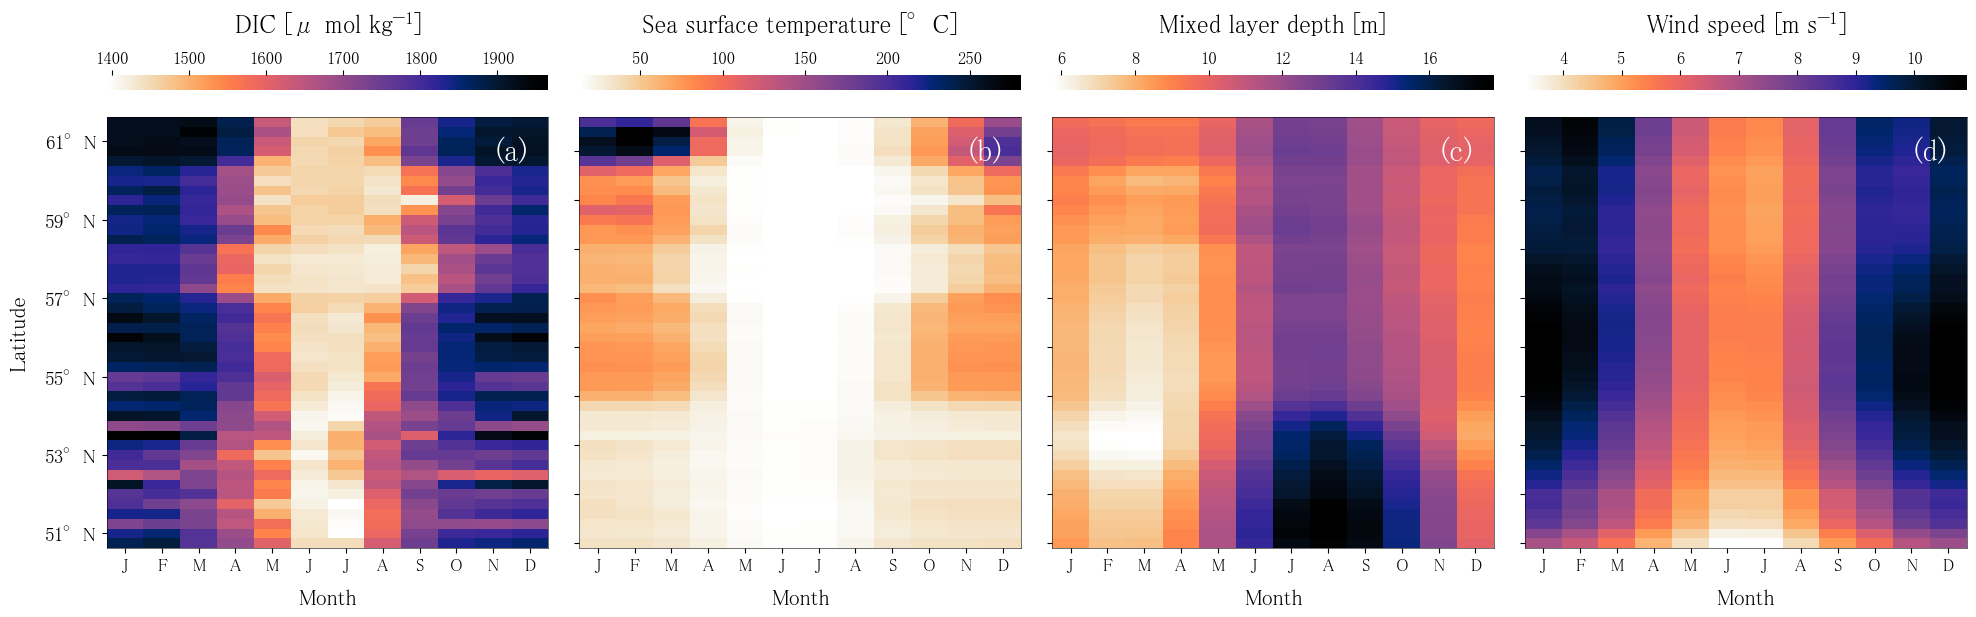

In [10]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(24, 7))
plt.subplots_adjust(wspace=0.07)

im1 = new_list[0].T.plot.pcolormesh(
        ax=ax1,
        cmap=cmap,
        add_colorbar=False
        )
im2 = new_list[1].somxl010.T.plot.pcolormesh(
        ax=ax2,
        cmap=cmap,
        add_colorbar=False
        )
im3 = new_list[2].isel(time=0).sst.T.plot.pcolormesh(
        ax=ax3,
        cmap=cmap,
        add_colorbar=False
        )
im4 = new_list[3].wind.T.plot.pcolormesh(
        ax=ax4,
        cmap=cmap,
        add_colorbar=False
        )

cbar_dic = plt.colorbar(im1, ax=ax1, aspect = 30, pad=0.05, location='top')
cbar_dic.set_label('DIC [μ mol $\mathregular{kg^{-1}}$]', fontsize=18, labelpad=14)

cbar_sst = plt.colorbar(im2, ax=ax2, aspect = 30, pad=0.05, location='top')
cbar_sst.set_label('Sea surface temperature [°C]', fontsize=18, labelpad=14)

cbar_mld = plt.colorbar(im3, ax=ax3, aspect = 30, pad=0.05, location='top')
cbar_mld.set_label('Mixed layer depth [m]', fontsize=18, labelpad=14)

cbar_wind = plt.colorbar(im4, ax=ax4, aspect = 30, pad=0.05, location='top')
cbar_wind.set_label('Wind speed [m $\mathregular{s^{-1}}$]', fontsize=18, labelpad=14)

cbars = [cbar_dic, cbar_sst, cbar_mld, cbar_wind]

axes_no = [ax2, ax3, ax4]

for ax in axes_no:
    ax.set(yticklabels=[])
    ax.set_ylabel('')

axes = [ax1, ax2, ax3, ax4]

for ax in axes:
    x = list(range(1,13))
    ax.set_xticks(np.arange(min(x), max(x)+1, 1))
    labels_month = [item.get_text() for item in ax.get_xticklabels()]
    month_label = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
    ax.set_xticklabels(month_label, fontsize=12)
    ax.set_xlabel('Month', fontsize=16, labelpad=12)
    ax.set_title('')
    
y = list(range(1,48))
ax1.set_yticks(np.arange(min(y), max(y), 8))
labels_lat = [item.get_text() for item in ax1.get_yticklabels()]
lat_label = ['51°N', '53°N', '55°N', '57°N', '59°N', '61°N']
ax1.set_yticklabels(lat_label, fontsize=14)
ax1.set_ylabel('Latitude', fontsize=16, labelpad=12)

for n, ax in enumerate(axes):
    ax.text(0.88, 0.9, string.punctuation[7] + string.ascii_lowercase[n] + string.punctuation[8],
            transform=ax.transAxes, size=22, weight='bold', color='white')
    
for location in ['left','bottom', 'right', 'top']:
    for ax in axes:
        ax.spines[location].set_linewidth(0.4)
    for cbar in cbars: 
        cbar.ax.set_frame_on(False)
        cbar.ax.tick_params(labelsize=12)
    
pass

plt.savefig('/Users/chiaraciscato/Desktop/GEOMAR/OAEseasonality/out/northSea.png')